In [1]:
import sys,os
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, hypergeom
from statsmodels.stats.multitest import fdrcorrection
from fisher import pvalue
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# import lifelines
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter


from method2 import read_bic_table
%matplotlib inline

In [2]:
def prepare_data_table(anno, exprs, 
                       time="OS", event="OS_status", event_codes = {"LIVING":0,"DECEASED":1},
                       covars = ["age","stage"]):

    anno = anno.loc[set(exprs.columns.values).intersection(anno.index.values),:]
    anno.loc[:,event] = anno.loc[:,event].replace(event_codes)
    data = anno.dropna(subset=[time,event]+covars,axis=0,how="any")
    
    data = data.loc[:,[time, event]+covars]

    for var in [time,event]+covars:
        data[var] = data[var].apply(lambda x: float(x))
    #for covar in covars:
    #    data[covar] -= data[covar].mean()
    #    data[covar] /= data[covar].std()
        
    data["in_bicluster"] = 0
    return data

def do_CPH(bics_df, anno_data, time="OS", event="OS_status", verbose = True):
    '''CPH fit '''
    i = 0
    p_vals = {}
    coef = {}
    coef_CI = {}
    bics_dict = bics_df.T.to_dict()
    
    for bic_id in bics_dict.keys():
        
        bic = bics_dict[bic_id]
        patients_in_module = bic["samples"]
        patients_in_module = set(patients_in_module).intersection(set(anno_data.index.values))
        data = anno_data.copy()
        data.loc[patients_in_module,"in_bicluster"] = 1
        cph = CoxPHFitter()
        try:
            res = cph.fit(data, duration_col=time, event_col= event, show_progress=False)
            res_table = res.summary
            res_table  = res_table.sort_values("p")
            p_val = res_table.loc["in_bicluster","p"] 
            p_vals[bic_id] = p_val
            coef[bic_id] = res_table.loc["in_bicluster","coef"]
            coef_CI[bic_id] = (res_table.loc["in_bicluster","coef lower 95%"],
                               res_table.loc["in_bicluster","coef upper 95%"])
            
        except:
            print("Failed CPH for id:",bic_id, "SNR:",bic["avgSNR"],
                  "n_genes:",bic["n_genes"],"n_samples:",bic["n_samples"],file = sys.stderr)
            p_vals[bic_id] = np.nan
            coef[bic_id] = np.nan
            coef_CI[bic_id] = (np.nan,np.nan)
    
    
    return pd.DataFrame({time+"_pval":pd.Series(p_vals),
                         time+"_coef":pd.Series(coef),
                         time+"_coef_CI":pd.Series(coef_CI)})


In [3]:
def plot_OS_run(df, ax, ytitle= False,xtitle=False, legend = False):
    ax.scatter(x = df["OS_coef"], y = df["-log10(adj.pval)"], 
               s=((df["avgSNR"])**2)*50,c=df["avgSNR"],
               linewidth=1,cmap="Reds",alpha=0.7,vmin=0, vmax=2.0)
    if xtitle:
        ax.set_title(xtitle)
    else:
        ax.set_xlabel("")
    if ytitle:
        ax.set_ylabel(ytitle)
    else:
        ax.set_ylabel("")
    #if legend:
        #cbar = plt.colorbar(label="avg. |SNR|")
        #cbar.set_clim(vmin=0, vmax=2.0)
    ax.plot([min(df["OS_coef"].values),max(df["OS_coef"].values)],
            [-np.log10(0.05),-np.log10(0.05)], 
            linewidth=1, linestyle='dashed')
    return ax

def plot_OS(os_bics,run_names,datasets):
    fig, axes = plt.subplots(len(run_names),len(datasets), figsize = (15,3*len(run_names)), sharey=True)

    for i in range(0,len(run_names)):
        run = run_names[i]
        for j in range(0,len(datasets)):
            ds = datasets[j]
            title = run+" "+ ds
            df = os_bics[run][ds]
            exclude = df.loc[(df["OS_coef"]<-5.0) & (df["OS_pval"]>0.9),: ]
            if exclude.shape[0] > 0:
                print(ds, run,"exclude records with high coef. and p.value~1.0:",exclude.shape[0])
                exclude = set(exclude.index.values)
                df = df.loc[set(df.index.values).difference(exclude)]
            xtitle, ytitle, legend = False, False, False
            df.loc[:,"-log10(adj.pval)"] = -1*np.log10(df["OS_pval_BH"])
            df.loc[:,"avgSNR"] = df["avgSNR"].apply(float)
            if i==0:
                xtitle=ds
                if j==0:
                    #legend = True
                    ytitle= run
            else:
                if j==0:
                    ytitle= run
            if df.shape[0]>0:
                axes[i][j] = plot_OS_run(df,axes[i][j], legend = legend, xtitle=xtitle, ytitle=ytitle )
    fig.subplots_adjust(wspace=0.05, hspace=0.25)
    # common X and Y titles
    fig.text(0.5, 0.10, 'log(HR)', ha='center', va='center',fontsize=12)
    fig.text(0.06, 0.5, r'$-\log_{10}$'+'(p-value)', va='center', ha='center', rotation='vertical', fontsize=12)

    # cmap for legend markers 
    cmap = matplotlib.cm.get_cmap('Reds')
    norm = matplotlib.colors.Normalize(vmin=0.0, vmax=2.0)

    # legend markers 
    pws = [0.5,1.0,1.5]
    for pw in pws:
        rgb_color = cmap(norm(pw))
        plt.scatter([], [], s=((pw)**2)*50,label=str(pw),linewidth=1, color=rgb_color)
    h, l = plt.gca().get_legend_handles_labels()
    axes[0][0].legend(h[1:], l[1:], title="avg. |SNR|", borderpad=0.5, 
                      frameon=True, framealpha=0.5, edgecolor="k", facecolor="w",loc= "upper left",
                      ncol = len(datasets),columnspacing=0.5,handletextpad=0.3,labelspacing=0.5,fancybox=True) #



In [4]:
def dedup(df_bics, J=0.5):
    df_bics = df_bics.sort_values(by="avgSNR",ascending=False)
    df_bics["is_dup"] = -1 
    for row in df_bics.iterrows():
        id1, bic = row
        if bic["is_dup"]==-1:
            genes = bic["genes"]
            samples = bic["samples"]
            avgSNR = bic["avgSNR"]

            df_bics2  = df_bics.tail(df_bics.shape[0]-id1-1)
            df_bics2  = df_bics2.loc[df_bics2["avgSNR"]<=avgSNR,:]
            df_bics2  = df_bics2.loc[df_bics2["is_dup"]==-1,:]
            for row2 in df_bics2.iterrows():
                id2, bic2 = row2
                if id1 != id2:
                    genes2 = bic2["genes"]
                    samples2 = bic2["samples"]
                    Jg = len(genes.intersection(genes2))*1.0/len(genes.union(genes2))
                    Js = len(samples.intersection(samples2))*1.0/len(samples.union(samples2))
                    if Js*Jg>J:
                        df_bics.loc[id2,"is_dup"] = id1
    df_bics = df_bics.loc[df_bics["is_dup"]==-1,:]
    df_bics.drop("is_dup",axis=1)
    df_bics.index = range(0,df_bics.shape[0])
    print(df_bics.shape[0],"biclusters survived deduplicaiton with J",J)
    return df_bics



In [5]:
# expressions and annotations
data_dir = "../datasets_14K/"

exprs_files = {"TCGA-RNAseq":"TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv",
               "METABRIC":"METABRIC_1904_14K.nolog2_exprs_z.tsv"}

anno_files = {"TCGA-RNAseq":"TCGA.annotation_v3.t.tsv",
               "METABRIC":"METABRIC.annotation_v3.t.tsv"}

# biclusters 
res_dir = "filtered_results/"
prefixes  = {"TCGA-RNAseq":"TCGA-BRCA_945","METABRIC":"METABRIC_1904"}

datasets = ["TCGA-RNAseq","METABRIC"]
exprs_dict = {}
anno_dict = {}

for ds in datasets:
    exprs =  pd.read_csv(data_dir + exprs_files[ds],sep = "\t", index_col=0)
    
    anno = pd.read_csv(data_dir + anno_files[ds],sep = "\t", index_col=0)
    anno = anno.loc[anno["stage"] != "X",:]
    
    samples = sorted(set(exprs.columns).intersection(set(anno.index)))
    print(len(samples),"samples in dataset", ds)
    
    anno_dict[ds] =  anno.loc[samples,:]
    exprs_dict[ds] = exprs.loc[:,samples]

935 samples in dataset TCGA-RNAseq
1904 samples in dataset METABRIC


In [12]:
runs = [0]
alphas = [10,1,0.1,0.01]
betas = [1,10,100,100000]
p_vals = [0.005]


anno_data_dict = {}
for ds in datasets:
    anno_data_dict[ds] = prepare_data_table(anno_dict[ds],exprs_dict[ds])
    print(ds,"samples remained after dropping NAs:",anno_data_dict[ds].shape[0])

os_bics = {}
run_names = []
for r in runs:
    os_bics["RUN "+str(r)]={}
    for ds in datasets:
        anno_data = anno_data_dict[ds]
        
        df_bics = []
        for pv in p_vals:
            for a in alphas:
                for b in betas:
                    fname = prefixes[ds]+"."+str(r)+".alpha="+str(a)+",beta_K="+str(b)+",pv="+str(pv)+".biclusters.FDR_0.01.tsv"
                    bics = read_bic_table(res_dir+fname)
                    print("\t",bics.shape[0], res_dir+fname)
                    df_bics.append(bics)
        df_bics = pd.concat(df_bics,axis=0)
        df_bics = df_bics.drop("id.1",axis=1)
        print(ds, df_bics.shape[0],"bicsluters")
        
        df_bics = df_bics.sort_values(by="avgSNR",ascending=False)
        df_bics.index = range(0,df_bics.shape[0])
        # remove duplicated biclusters (keep with highest SNR)
        df_bics = dedup(df_bics, J = 0.5)
        
        # test for OS
        cph_table = do_CPH(df_bics, anno_data)
        df_bics = pd.concat([df_bics, cph_table],axis=1)
        
        #failed_CPH = bics.loc[np.isnan(bics["OS_pval"]),:].index.values
        #    if len(failed_CPH)>0:
        #        print(name, ds, "Failed CPH:")
        #        print(bics.loc[failed_CPH,["n_genes","n_samples","avgSNR"]])
        #        bics = bics.loc[~np.isnan(bics["OS_pval"]),:]
        
        bh_res, adj_pval = fdrcorrection(df_bics["OS_pval"].values,alpha=0.05)
        df_bics.loc[:,"OS_pval_BH"] =  adj_pval
        os_bics["RUN "+str(r)][ds] = df_bics

TCGA-RNAseq samples remained after dropping NAs: 928
METABRIC samples remained after dropping NAs: 1403
	 30 filtered_results/TCGA-BRCA_945.0.alpha=10,beta_K=1,pv=0.005.biclusters.FDR_0.01.tsv
	 36 filtered_results/TCGA-BRCA_945.0.alpha=10,beta_K=10,pv=0.005.biclusters.FDR_0.01.tsv
	 29 filtered_results/TCGA-BRCA_945.0.alpha=10,beta_K=100,pv=0.005.biclusters.FDR_0.01.tsv
	 32 filtered_results/TCGA-BRCA_945.0.alpha=10,beta_K=100000,pv=0.005.biclusters.FDR_0.01.tsv
	 41 filtered_results/TCGA-BRCA_945.0.alpha=1,beta_K=1,pv=0.005.biclusters.FDR_0.01.tsv
	 38 filtered_results/TCGA-BRCA_945.0.alpha=1,beta_K=10,pv=0.005.biclusters.FDR_0.01.tsv
	 41 filtered_results/TCGA-BRCA_945.0.alpha=1,beta_K=100,pv=0.005.biclusters.FDR_0.01.tsv
	 47 filtered_results/TCGA-BRCA_945.0.alpha=1,beta_K=100000,pv=0.005.biclusters.FDR_0.01.tsv
	 11 filtered_results/TCGA-BRCA_945.0.alpha=0.1,beta_K=1,pv=0.005.biclusters.FDR_0.01.tsv
	 6 filtered_results/TCGA-BRCA_945.0.alpha=0.1,beta_K=10,pv=0.005.biclusters.FDR_0

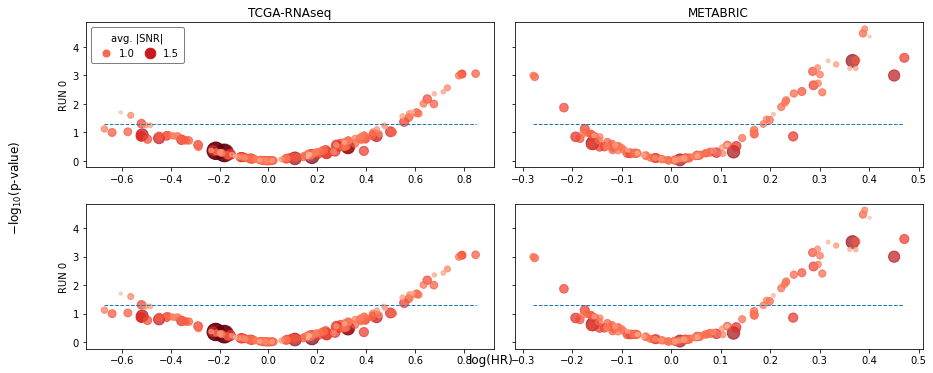

In [13]:
run_names = list(os_bics.keys())
run_names
plot_OS(os_bics,run_names+run_names,datasets)

In [21]:
results = []
for name in run_names:
    for ds in datasets:
        bics = os_bics[name][ds]
        bics["run_name"] = name
        bics["dataset"] = ds
        print(ds,":", bics.loc[bics["OS_pval_BH"]<0.05,:].shape[0],"signif. surv. ")
        results.append(bics)
results = pd.concat(results,axis=0)
signif = results.loc[results["OS_pval_BH"]<0.05,:]
signif = signif.sort_values(by="OS_pval_BH",ascending = True)
from method2 import write_bic_table
signif.index = range(0,signif.shape[0])
signif["id"]  = signif.index
write_bic_table(signif,"../OS_biclusters.tsv")

TCGA-RNAseq : 23 signif. surv. 
METABRIC : 29 signif. surv. 


In [22]:
def find_bm(bic, bics2):
    # returns BM by genes, 
    bm_J,bm_id = 0, -1
    for i in bics2.keys():
        bic2 = bics2[i]
        J = len(bic["genes"].intersection(bic2["genes"]))*1.0/len(bic["genes"].union(bic2["genes"]))
        if J > bm_J:
            bm_J = J
            bm_id = i
    if bm_id >-1:
        shared_genes = bic["genes"].intersection(bics2[bm_id]["genes"])
        sh_exp= len(bic["genes"])*len(bics2[bm_id]["genes"])*1.0/11959
        J_exp = sh_exp/(len(bic["genes"])*len(bics2[bm_id]["genes"])-sh_exp)
        return {"Jg":bm_J,"n_shared_genes":len(shared_genes), "n_bm_genes":len(bics2[bm_id]["genes"]),
                "shared_genes":" ".join(sorted(shared_genes)), "bm_genes":" ".join(sorted(bics2[bm_id]["genes"])),
                "bm_samples":" ".join(sorted(bics2[bm_id]["samples"])),
                "n_expected":sh_exp, "expected_Jg":J_exp,"bm_id":bm_id,"log10(Jobs/Jexp)":np.log10(bm_J/J_exp)}
    else:
        return {"Jg":0,"n_shared_genes":0,
                "shared_genes":"","bm_id":"NA"}
    
ds1, ds2 = datasets
results = signif

bics_df = results.loc[results["dataset"]==ds1,:]
bics = bics_df.T.to_dict()
bics2_df = results.loc[results["dataset"]==ds2,:]
bics2 = bics2_df.T.to_dict()

Js = {}
for i in bics.keys():
    bic = bics[i]
    Js[i] = find_bm(bic, bics2)
bics_bms = pd.DataFrame.from_dict(Js).T

Js = {}
for i in bics2.keys():
    bic = bics2[i]
    Js[i] = find_bm(bic, bics)
bics2_bms = pd.DataFrame.from_dict(Js).T

bics = pd.concat([bics_bms, bics_df],axis=1)
bics["comparison"] = ds1+" -> "+ ds2
bics2 = pd.concat([bics2_bms, bics2_df],axis=1)
bics2["comparison"] = ds2+" -> "+ ds1
cols = ["id","bm_id","comparison",
        "Jg","expected_Jg","log10(Jobs/Jexp)",
        "n_shared_genes","shared_genes","n_genes","genes","samples","n_bm_genes","bm_genes","bm_samples"]

df = pd.concat([bics[cols],bics2[cols]],axis=0)
df["id"] = df.index
df.index = range(df.shape[0])
df = df.dropna()
df = df.sort_values(by="n_shared_genes",ascending=False)
df["genes"] = df["genes"].apply(lambda x: " ".join(sorted(x)))
df["samples"] = df["samples"].apply(lambda x: " ".join(sorted(x)))
#df["bm_genes"] = df["bm_genes"].apply(lambda x: " ".join(x))
df.to_csv("../best_matches_all.tsv",sep="\t")
df

,id,bm_id,comparison,Jg,expected_Jg,log10(Jobs/Jexp),n_shared_genes,shared_genes,n_genes,genes,samples,n_bm_genes,bm_genes,bm_samples
31,64,7,TCGA-RNAseq -> METABRIC,0.250936,8.3626e-05,3.47722,67,ACOT4 AGR2 AGR3 ANKRA2 ANXA9 ARSG BCL2 C1orf21...,158,ABCC8 ACADSB ACOT4 AGR2 AGR3 AK8 ANKRA2 ANXA9 ...,TCGA-A1-A0SB-01 TCGA-A1-A0SK-01 TCGA-A1-A0SO-0...,176,ACOT4 ADIRF AFF3 AGR2 AGR3 ALDH6A1 ANKRA2 ANKR...,MB-0000 MB-0045 MB-0048 MB-0054 MB-0060 MB-006...
172,7,64,METABRIC -> TCGA-RNAseq,0.250936,8.3626e-05,3.47722,67,ACOT4 AGR2 AGR3 ANKRA2 ANXA9 ARSG BCL2 C1orf21...,176,ACOT4 ADIRF AFF3 AGR2 AGR3 ALDH6A1 ANKRA2 ANKR...,MB-0000 MB-0045 MB-0048 MB-0054 MB-0060 MB-006...,158,ABCC8 ACADSB ACOT4 AGR2 AGR3 AK8 ANKRA2 ANXA9 ...,TCGA-A1-A0SB-01 TCGA-A1-A0SK-01 TCGA-A1-A0SO-0...
171,6,27,METABRIC -> TCGA-RNAseq,0.129909,8.3626e-05,3.1913,43,ACOX2 ANKRD20A11P C16orf45 CCDC103 CFAP69 CFAP...,198,ABAT ABCC8 ABCD3 ABLIM3 ACOX2 ADCY1 ADCY9 AGR2...,MB-0000 MB-0005 MB-0006 MB-0022 MB-0045 MB-004...,176,ACOX2 ANG ANKRD20A11P ASTN2 ATP1A4 BAIAP3 BDNF...,TCGA-3C-AALI-01 TCGA-5T-A9QA-01 TCGA-A1-A0SB-0...
6,27,6,TCGA-RNAseq -> METABRIC,0.129909,8.3626e-05,3.1913,43,ACOX2 ANKRD20A11P C16orf45 CCDC103 CFAP69 CFAP...,176,ACOX2 ANG ANKRD20A11P ASTN2 ATP1A4 BAIAP3 BDNF...,TCGA-3C-AALI-01 TCGA-5T-A9QA-01 TCGA-A1-A0SB-0...,198,ABAT ABCC8 ABCD3 ABLIM3 ACOX2 ADCY1 ADCY9 AGR2...,MB-0000 MB-0005 MB-0006 MB-0022 MB-0045 MB-004...
184,25,64,METABRIC -> TCGA-RNAseq,0.184524,8.3626e-05,3.34371,31,AGR3 CA12 CAPN8 CMBL DACH1 DEGS2 DNALI1 ESR1 F...,41,ADIRF AGR3 ANKRD30A CA12 CAPN8 CMBL CNRIP1 DAC...,MB-0000 MB-0045 MB-0048 MB-0060 MB-0062 MB-007...,158,ABCC8 ACADSB ACOT4 AGR2 AGR3 AK8 ANKRA2 ANXA9 ...,TCGA-A1-A0SB-01 TCGA-A1-A0SK-01 TCGA-A1-A0SO-0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,119,176,TCGA-RNAseq -> METABRIC,0.2,8.3626e-05,3.37869,1,MS4A1,3,CD79A KIAA0125 MS4A1,TCGA-3C-AAAU-01 TCGA-3C-AALI-01 TCGA-3C-AALJ-0...,3,CPA4 MS4A1 TPSAB1,MB-0000 MB-0002 MB-0005 MB-0008 MB-0014 MB-002...
169,4,100,METABRIC -> TCGA-RNAseq,0.2,8.3626e-05,3.37869,1,CTPS1,3,CTPS1 SKP2 SRPK1,MB-0046 MB-0060 MB-0062 MB-0079 MB-0100 MB-010...,3,CTPS1 KIAA0020 RIOK1,TCGA-A1-A0SK-01 TCGA-A1-A0SO-01 TCGA-A2-A04P-0...
72,129,180,TCGA-RNAseq -> METABRIC,0.047619,8.3626e-05,2.75544,1,TSPAN15,4,DNAAF3 DNAH5 TSPAN15 UBXN10,TCGA-A1-A0SB-01 TCGA-A1-A0SK-01 TCGA-A1-A0SO-0...,18,BPNT1 CCNO CRAT CYP4X1 CYP4Z1 CYP4Z2P EHF GGT6...,MB-0002 MB-0006 MB-0008 MB-0036 MB-0039 MB-004...
166,1,87,METABRIC -> TCGA-RNAseq,0.166667,8.3626e-05,3.29951,1,AFF3,3,ADIRF AFF3 MAPT,MB-0005 MB-0035 MB-0045 MB-0054 MB-0060 MB-006...,4,AFF3 TPTE2P2 WNK4 ZSWIM5,TCGA-3C-AALI-01 TCGA-A1-A0SB-01 TCGA-A1-A0SK-0...


In [15]:


def calc_bm_dist(OS_results, method,ds1, ds2,OS_pval = 1.0):
    bics_df = OS_results[method][ds1]
    bics_df = bics_df.loc[bics_df["OS_pval_BH"]<OS_pval,:]
    bics = bics_df.T.to_dict()
    bics2_df = OS_results[method][ds2]
    bics2_df = bics2_df.loc[bics2_df["OS_pval_BH"]<OS_pval,:]
    bics2 = bics2_df.T.to_dict()

    Js = {}
    for i in bics.keys():
        bic = bics[i]
        Js[i] = find_bm(bic, bics2)
    bics_bms = pd.DataFrame.from_dict(Js).T

    Js = {}
    for i in bics2.keys():
        bic = bics2[i]
        Js[i] = find_bm(bic, bics)
    bics2_bms = pd.DataFrame.from_dict(Js).T

    bics = pd.concat([bics_bms, bics_df],axis=1)
    bics["comparison"] = ds1+" vs "+ ds2
    bics2 = pd.concat([bics2_bms, bics2_df],axis=1)
    bics2["comparison"] = ds2+" vs "+ ds1
    cols = ["id","bm_id","comparison",
            "Jg","expected_Jg","log10(Jobs/Jexp)",
            "n_shared_genes","n_expected","shared_genes"]

    df = pd.concat([bics[cols],bics2[cols]],axis=0)
    df["id"] = df.index
    df.index = range(df.shape[0])
    df["method"] = method
    return df

In [ ]:




def module_KM_plot(data):
    kmf = KaplanMeierFitter()
    ax = plt.subplot(1, 1, 1)
    l_dict = {1:"in module",0:"not in module"}
    for value in [0,1]:
        ix = data['in_module'] == value
        kmf.fit(data.loc[ix,"OS"], data.loc[ix,"OS_status"], label=l_dict[value])
        kmf.plot(ax=ax, legend=True)
    ax.set_xlabel("months")
